# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
    calculate_fidelity
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    resonator_spectroscopy_g_vs_e,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

In [2]:
from cycler import cycler
plt.rcParams.update({
    'font.family': 'ZI Akkurat',
    'font.weight': 'light',
    'axes.labelweight': 'light',
    'axes.titleweight': 'normal',
    'svg.fonttype': 'none', #Make text editable in SVG
    'text.usetex': False
})

In [3]:
blue_color_zi = '#009EE0'
orange_color_zi = '#EE7F00'
dark_blue_color_zi = '#172983'

## 2. Set-up


### Emulation Mode


In [4]:
emulate = False

### Database Set-up


In [5]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [6]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [7]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748945327.5086765,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=-1251043386.209137,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=-1251043386.209137,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': 

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [8]:
# create and connect to a session
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.28 15:17:41.124 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.28 15:17:41.126 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:17:41.126 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:17:41.179 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:17:42.650 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:17:42.795 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [9]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)
session.connect(do_emulation=False, reset_devices=True)
compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.28 14:59:39.136 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 14:59:39.137 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 14:59:39.144 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 14:59:40.536 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 14:59:40.685 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 14:59:40.885 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 14:59:40.961 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 14:59:41.183 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.28 14:59:41.183 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.28 14:59:41.184 laboneq.compiler.workflow.co

Text(0.5, 1.0, 'CW resonator spectroscopy, large range')

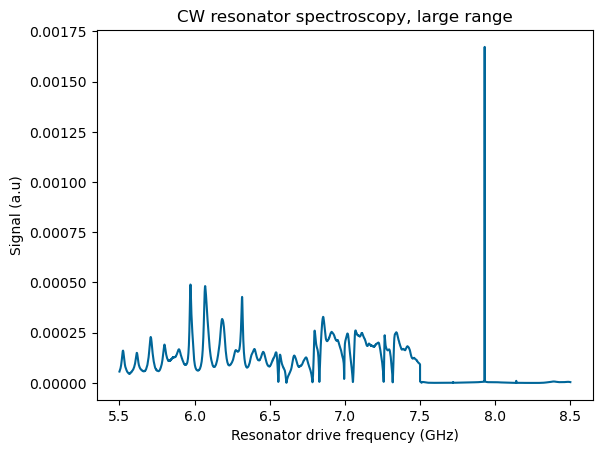

In [11]:
# access and plot results of one 8GHz sweep
gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep/1e9, np.array(flatten([data for data in gnd_signal])))
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, large range")

In [12]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

In [9]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 210e6, 290e6, 401),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
#plot_results(cw_spectroscopy_results)

2023.09.28 15:17:47.022 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:17:47.023 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:17:47.034 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:17:48.450 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:17:48.597 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:17:48.841 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:17:48.873 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:17:48.930 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.28 15:17:48.933 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.28 15:17:48.933 laboneq.compiler.workflow.co

### Make nice resonator spectroscopy plot

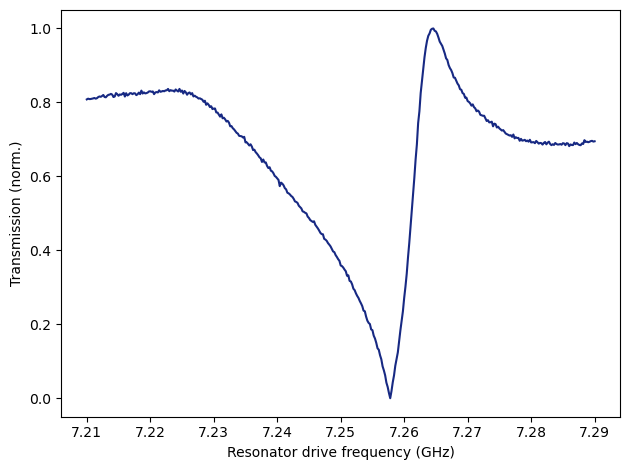

In [10]:
lo_frequency = cw_spectroscopy_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))
full_sweep = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

gnd_signal = gnd_signal/max(gnd_signal)

plt.plot(full_sweep/1e9, gnd_signal, color = dark_blue_color_zi)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Transmission (norm.)")
plt.tight_layout()

In [11]:
#analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [12]:
first_readout_res = lo_frequency + 0.258e9
print(first_readout_res)

7258000000.0


In [13]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

# Spectroscopy vs Power - "Punchout" NOT TESTED


2023.09.28 15:00:33.506 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:00:33.506 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:00:33.510 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:00:34.926 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:00:35.068 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:00:35.316 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:00:35.395 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:00:35.753 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 23
2023.09.28 15:00:35.754 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3200
2023.09.28 15:00:35.754 laboneq.compiler.workflow

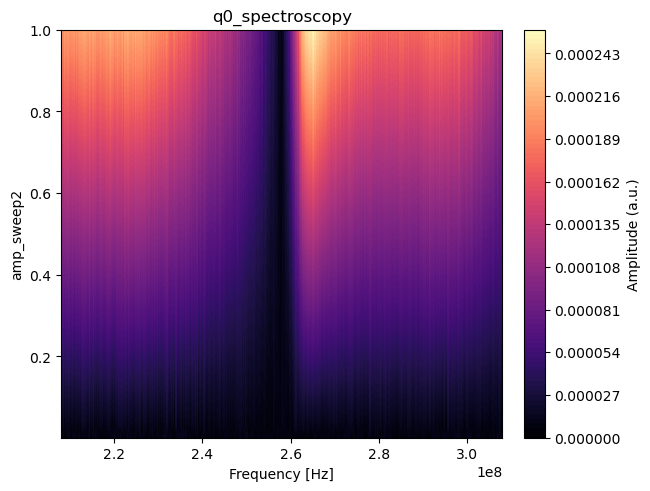

In [18]:
if True:
    freq_upper = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        + 50e6
    )
    freq_lower = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        - 50e6
    )

    amp_sweep = SweepParameter(
        uid="amp_sweep2",
        values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=3),
    )

    punchout = res_spectroscopy_pulsed_amp_sweep(
        qubit=transmon_list[0],
        integration_kernel=integration_kernel,
        readout_pulse=readout_gauss_square_pulse,
        frequency_sweep=create_freq_sweep(
            f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
        ),
        amplitude_sweep=amp_sweep,
        num_averages=2**8,
        measure_range=-25,
        acquire_range=-5,
    )

    session.connect(do_emulation=False, reset_devices=True)
    comp_punchout = session.compile(punchout)
    punchout_result = session.run(comp_punchout)

    plot_results(punchout_result)

In [ ]:
if False:
    save_results(
        demo_results_db,
        punchout_result,
        "punchout",
        "neg_25_meas_neg_5_acq_range",
    )

In [ ]:
if False:
    qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

    transmon_list = update_qubit_parameters_and_calibration(
        qubit_parameters, demo_setup, demo_setup_db
    )

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [14]:
def gen_const_pulse(qubit, length=15e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [15]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-30
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [21]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=6e6,
    qspec_num=251,
    num_averages=2**10,
)


In [22]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)

2023.09.28 15:02:05.732 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:02:05.733 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:02:05.739 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:02:07.116 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:02:07.258 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:02:07.509 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:02:07.535 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:02:09.215 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 46
2023.09.28 15:02:09.216 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3264
2023.09.28 15:02:09.217 laboneq.compiler.workflow

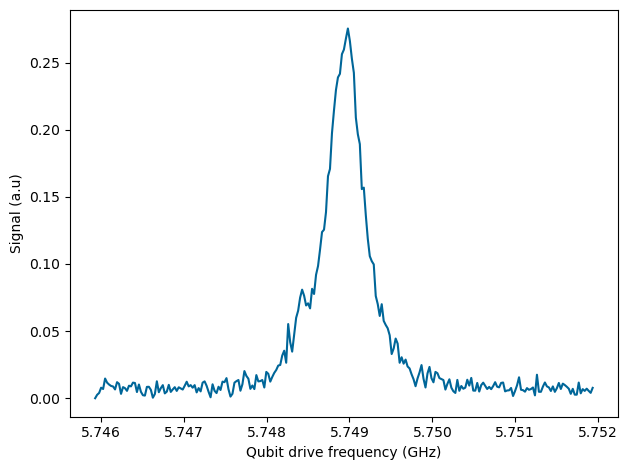

In [23]:
lo_frequency = qubit_parameters["qubits"]["q0"]["drive_lo_frequency"]["value"]

gnd_signal = abs(qspec_res.get_data("q0_spectroscopy") - qspec_res.get_data("q0_spectroscopy")[0])
gnd_signal = gnd_signal
#gnd_signal = abs(qspec_res.get_data("q0_spectroscopy"))
full_sweep = qspec_res.get_axis("q0_spectroscopy")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal)
plt.xlabel("Qubit drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.tight_layout()

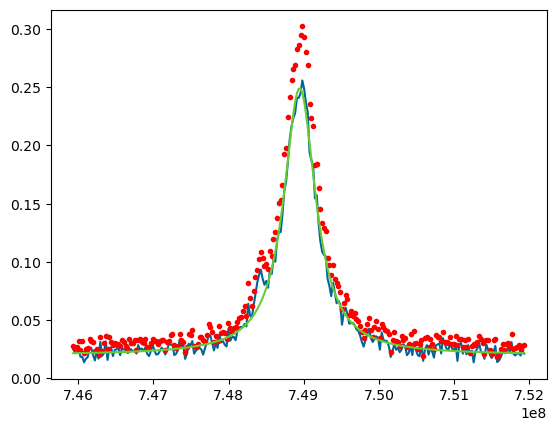

748945327.508677


In [24]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.49e8,a=0.03,gamma=1E6, flip=True, rotate = True)
print(qubit_resonance)

### Update qubit resonance

In [25]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748945327.508677


# Amplitude Rabi

In [16]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [17]:
def amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_rabi = Experiment(
        uid="Qubit Spectroscopy",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
            ]
        ),
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi amplitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
                # qubit drive
                with exp_rabi.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_rabi.play(
                        signal=f"drive_{qubit.uid}",
                        pulse=drive_pulse(qubit, amplitude=1),
                        amplitude=amplitude_sweep,
                    )
                # measurement
                with exp_rabi.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_rabi.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_rabi",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
        if cal_trace:
            with exp_rabi.section(uid="cal_trace_gnd_meas"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=1e-6, # qubit.parameters.user_defined["reset_delay_length"],
                )
            with exp_rabi.section(uid="cal_trace_exc", play_after="cal_trace_gnd_meas"):
                exp_rabi.play(
                    signal=f"drive_{qubit.uid}",
                    pulse=drive_pulse(qubit, amplitude = 1),
                    amplitude = pi_amplitude,
                )
                
            with exp_rabi.section(uid="cal_trace_exc_meas", play_after="cal_trace_exc"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                )
            

    return exp_rabi

In [18]:
amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=0.9, count=51)


amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=amplitude_sweep,
    num_averages=2**10,
    pi_amplitude=transmon_list[0].parameters.user_defined["amplitude_pi"],
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)


2023.09.28 15:18:36.194 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:18:36.205 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:18:36.248 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 188
2023.09.28 15:18:36.249 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4032
2023.09.28 15:18:36.250 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.28 15:18:36.252 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:18:36.252 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:18:36.260 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:18:37.584 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:18:37.726 laboneq.controller.devices.device

### Make nice plot for Rabi oscillations

In [19]:
def rabi_curve(x, offset, phase_shift, amplitude, period):
    return amplitude * np.sin(np.pi / period * x - phase_shift) + offset

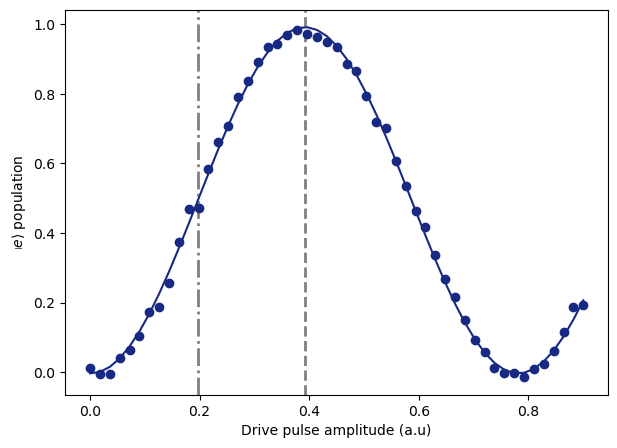

In [20]:
handles = list(rabi_res.acquired_results.keys())
res1 = np.asarray(rabi_res.get_data(handles[0]))
res_cal_trace= np.asarray(rabi_res.get_data(handles[1]))
axis1 = rabi_res.get_axis(handles[0])[0]
delta_x = axis1[-1]-axis1[-2]
axis2 = np.linspace(axis1[-1]+delta_x,axis1[-1] + 2*delta_x,2)

delta_vec = res_cal_trace[1] -res_cal_trace[0]
angle = np.angle(delta_vec)
rd = []
for r in [res1,res_cal_trace]:
    r = r - res_cal_trace[0]
    r = r * np.exp(-1j*angle)
    r = r/ np.abs(delta_vec)
    rd.append(r)
    
offset_guess = np.mean(np.real(rd[0]))
phase_shift_guess = np.pi / 2
amplitude_guess = (max(np.real(rd[0])) - min(np.real(rd[0]))) / 2
period_guess = abs(axis1[np.argmax(np.real(rd[0]))] - axis1[np.argmin(np.real(rd[0]))])
p0 = [offset_guess, phase_shift_guess, amplitude_guess, period_guess]
popt = scipy.optimize.curve_fit(rabi_curve, axis1, np.real(rd[0]), p0=p0)[0]

pi_amp = scipy.optimize.fmin(
    lambda x: -rabi_curve(x, *popt), axis1[np.argmax(np.real(rd[0]))], disp=False
)[0]
pi2_amp = scipy.optimize.fmin(
    lambda x: abs(rabi_curve(x, *popt) - popt[0]), pi_amp / 2, disp=False
)[0]

plt.figure(figsize=(7, 5))
plt.xlabel('Drive pulse amplitude (a.u)')
plt.ylabel(r"$\left| e\right\rangle$ population")
plt.plot(axis1,np.real(rd[0]),'o', color = dark_blue_color_zi)
plt.plot(axis1, rabi_curve(axis1, *popt), color = dark_blue_color_zi)
plt.axvline(x=pi_amp, color='gray', linestyle='--', linewidth=2, zorder = -1)
plt.axvline(x=pi2_amp, color='gray', linestyle='-.', linewidth=2, zorder = -1)


In [21]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = float(pi_amp)
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = float(pi2_amp)


transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## T1 measurement

In [32]:
delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)

t1_meas = t1_parallel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=2**10,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

2023.09.28 15:03:55.346 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:03:55.357 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:03:55.390 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 312
2023.09.28 15:03:55.391 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3616
2023.09.28 15:03:55.391 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.28 15:03:55.392 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:03:55.392 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004


2023.09.28 15:03:55.396 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:03:56.857 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:03:57.002 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:03:57.818 laboneq.controller.controller  INFO   Starting near-time execution...
2023.09.28 15:03:58.224 laboneq.controller.controller  INFO   Estimated RT execution time: 10.49 s.
2023.09.28 15:04:09.002 laboneq.controller.controller  INFO   Finished near-time execution.


T1 found to be 22.916 us.


2.291555060910944e-05

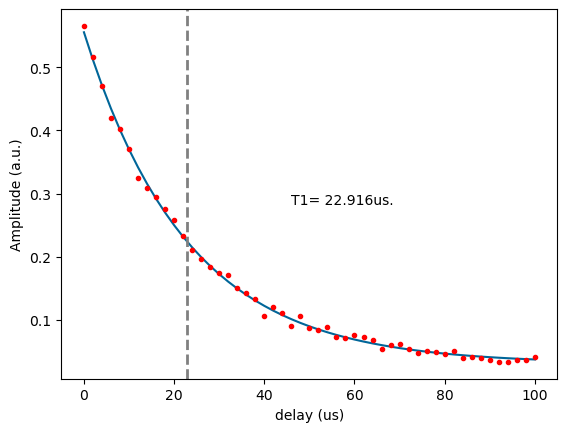

In [33]:
evaluate_T1(t1_res, "q0_t1")

## Ramsey

In [91]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    detuning = 0,
    cal_trace=False,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )


    

 #   readout_weight = readout_pulse
    freq = qubits[0].parameters.resonance_frequency_ge + detuning - qubits[0].parameters.drive_lo_frequency
  #  else:
   #     freq = detuning
         
    
    calibration = Calibration()   
    calibration["drive_q0"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq,
            modulation_type=ModulationType.HARDWARE
        )
    )

    exp_ramsey.set_calibration(calibration)

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        for qubit in qubits:
            # inner loop - real time sweep of Ramsey time delays
            with exp_ramsey.sweep(
                uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
            ):
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
            if cal_trace:
                with exp_ramsey.section(uid="cal_trace_gnd"):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey_cal_trace",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=1e-6 # qubit.parameters.user_defined["reset_delay_length"],
                    )
                with exp_ramsey.section(uid="cal_trace_exc"):
                    exp_ramsey.play(
                        signal=f"drive_{qubit.uid}",
                        pulse=drive_pulse(qubit),
                        amplitude=qubits[0].parameters.user_defined['amplitude_pi'],
                    )
                    
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey_cal_trace",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )

    return exp_ramsey

In [92]:
qubit_parameters["qubits"]["q0"]["reset_delay_length"]["value"] = 100e-6
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [93]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

### Set detuning freq

In [94]:
detuning_freq = .3e6

In [95]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=40e-6, count=151)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, detuning=detuning_freq, cal_trace=True)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.09.27 17:46:46.942 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.27 17:46:46.943 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.27 17:46:46.949 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.27 17:46:48.298 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.27 17:46:48.435 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.27 17:46:48.646 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.27 17:46:48.669 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.27 17:46:48.757 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 1391
2023.09.27 17:46:48.758 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5696
2023.09.27 17:46:48.758 laboneq.compiler.workfl

In [96]:
def ramsey_curve(x, offset, phase_shift, amplitude, period, t2):
        return (
            amplitude * np.exp(-x / t2) * np.sin(2 * np.pi * x / period + phase_shift)
            + offset
        )

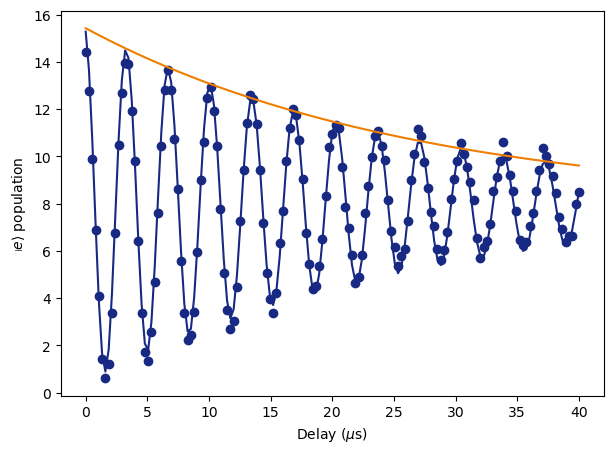

In [97]:
handles = list(res_ramsey.acquired_results.keys())
res1 = np.asarray(res_ramsey.get_data(handles[0]))
res_cal_trace= np.asarray(res_ramsey.get_data(handles[1]))
axis1 = res_ramsey.get_axis(handles[0])[0]

delta_vec = res_cal_trace[1] - res_cal_trace[0]
angle = np.angle(delta_vec)
rd = []
for r in [res1,res_cal_trace]:
    r = r - res_cal_trace[0]
    r = r * np.exp(-1j*angle)
    r = r/ np.abs(delta_vec)
    rd.append(r)

offset_guess = np.mean(np.real(rd[0]))
phase_shift_guess = np.pi / 2 if np.real(rd[0])[0] > np.real(rd[0])[-1] else -np.pi / 2
amplitude_guess = (max(np.real(rd[0])) - min(np.real(rd[0]))) / 2
period_guess = 2 * abs(axis1[np.argmax(np.real(rd[0]))] - axis1[np.argmin(np.real(rd[0]))])
t2_guess = 10e-6
# TODO: Refine t2 guess algorithm, potentially by finding peaks and fitting only them

p0 = [offset_guess, phase_shift_guess, amplitude_guess, period_guess, t2_guess]
popt = scipy.optimize.curve_fit(ramsey_curve, axis1, np.real(rd[0]), p0=p0)[0]

t2 = popt[4]
detuning_freq_measured = 1 / popt[3]

envelope_param = np.copy(popt)
envelope_param[3] = 1e9
envelope_param[1] = np.pi / 2

plt.figure(figsize=(7, 5))
plt.xlabel(r'Delay ($\mu$s)')
plt.ylabel(r"$\left| e\right\rangle$ population")
plt.plot(axis1*1e6,np.real(rd[0]),'o', color = dark_blue_color_zi)
plt.plot(axis1*1e6, ramsey_curve(axis1, *popt), color = dark_blue_color_zi)
plt.plot(axis1*1e6, ramsey_curve(axis1, *envelope_param), color = orange_color_zi)


In [103]:
print('T2 = {:.3f} us'.format(1e6*t2))

T2 = 26.689 us


### Update qubit resonance frequency

In [104]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] = float (qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] + detuning_freq_measured - detuning_freq)
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748932613.790863


# Active reset

## Optimize resonance freq

In [22]:
# resonator_spectroscopy gnd
gnd_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = None,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_g", 210e6, 290e6, 201),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**12,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_gnd_cw = session.compile(gnd_cw)
show_pulse_sheet("gnd_cw", compiled_gnd_cw)
gnd_cw_results = session.run(compiled_gnd_cw)

2023.09.28 15:19:21.544 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:19:21.545 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:19:21.550 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:19:23.048 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:19:23.188 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:19:23.435 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:19:23.476 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:19:23.552 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.28 15:19:23.552 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3200
2023.09.28 15:19:23.553 laboneq.compiler.workflow

In [23]:
# resonator_spectroscopy_pi
excitation_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_e", 210e6, 290e6, 201),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**12,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_excitation_cw = session.compile(excitation_cw)
show_pulse_sheet("exc_cw", compiled_excitation_cw)
excitation_cw_results = session.run(compiled_excitation_cw)

2023.09.28 15:19:27.647 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:19:27.648 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:19:27.655 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:19:29.069 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:19:29.209 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:19:29.454 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:19:29.484 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:19:29.698 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.28 15:19:29.699 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 3616
2023.09.28 15:19:29.699 laboneq.compiler.workflow

### Optimize readout freq based on IQ distance

In [36]:
gnd_signal = gnd_cw_results.get_data("resonator_spectroscopy_q0")
exc_signal = excitation_cw_results.get_data("resonator_spectroscopy_q0")
full_sweep = gnd_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

In [37]:
diff_res_signal = abs(exc_signal - gnd_signal)
max_res_signal = np.max(diff_res_signal)
max_res_signal_idx = np.argmax(diff_res_signal)
opt_res_freq = full_sweep[np.argmax(diff_res_signal)]
print(f"Optimized res freq {opt_res_freq/1e9} GHz gives max signal {max_res_signal}")

Optimized res freq 7.26 GHz gives max signal 0.00011585609922561058


In [38]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = float(opt_res_freq)

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

### Nice plot for optimized resonator readout frequency

Text(0, 0.5, 'Q (norm.)')

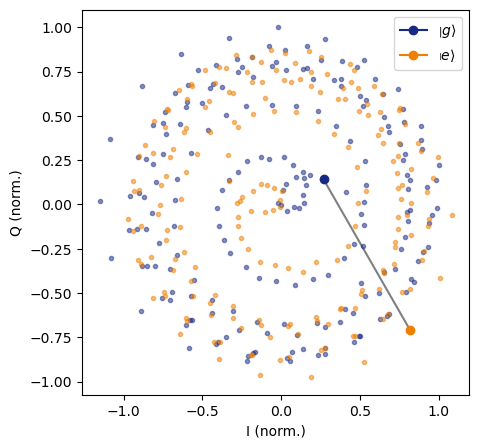

In [39]:
fig = plt.figure(figsize=(5, 5))

plt.plot(np.real(gnd_signal)/np.max(np.real(gnd_signal)), np.imag(gnd_signal)/np.max(np.imag(gnd_signal)), '.', color=dark_blue_color_zi, alpha = 0.5)
plt.plot(np.real(exc_signal)/np.max(np.real(gnd_signal)), np.imag(exc_signal)/np.max(np.imag(gnd_signal)), '.', color=orange_color_zi, alpha = 0.5)

opt_real = [np.real(gnd_signal[max_res_signal_idx])/np.max(np.real(gnd_signal)), np.real(exc_signal[max_res_signal_idx])/np.max(np.real(gnd_signal))]
opt_imag = [np.imag(gnd_signal[max_res_signal_idx])/np.max(np.imag(gnd_signal)), np.imag(exc_signal[max_res_signal_idx])/np.max(np.imag(gnd_signal))]

plt.plot(opt_real[0], opt_imag[0], color = dark_blue_color_zi, marker = 'o', label=r"$\left| g\right\rangle$")
plt.plot(opt_real[1], opt_imag[1], color = orange_color_zi, marker = 'o', label=r"$\left| e\right\rangle$")
plt.plot(opt_real, opt_imag, color = 'grey', zorder = -1)

plt.legend()
plt.xlabel("I (norm.)")
plt.ylabel("Q (norm.)")

### Nice plot for resonator spectroscopy in g and e

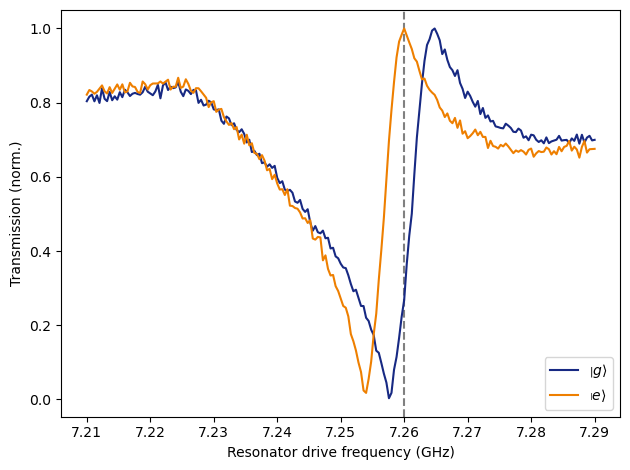

In [40]:
lo_frequency = gnd_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(gnd_cw_results.get_data("resonator_spectroscopy_q0"))

gnd_signal = gnd_signal/max(gnd_signal)

exc_signal = abs(excitation_cw_results.get_data("resonator_spectroscopy_q0"))
full_sweep2 = excitation_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency
exc_signal = exc_signal/max(exc_signal)

plt.plot(full_sweep/1e9, gnd_signal, label=r"$\left| g\right\rangle$", color=dark_blue_color_zi)
plt.plot(full_sweep2/1e9, exc_signal, label=r"$\left| e\right\rangle$", color=orange_color_zi)
plt.axvline(x=opt_res_freq/1e9, linestyle='--', color = 'grey', zorder=-1)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Transmission (norm.)")
plt.legend(loc = "lower right")
plt.tight_layout()

## Optimize kernels

In [41]:
def gen_exp_ref_trace(
    qubit,
    drive_pulse,
    readout_pulse,
    num_averages=2**8,
    excited=True,
):
    measure_pulse = readout_pulse(qubit)
    integration_length = measure_pulse.length + 300e-9
    print(f"integration length {integration_length}")
    exp_uid = "Exp_ref_trace_exc"
    
    exp_ref_trace = Experiment(
        uid=exp_uid,
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    
    ## define experimental sequence
    with exp_ref_trace.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        acquisition_type=AcquisitionType.RAW,
        #acquisition_type=AcquisitionType.INTEGRATION,
    ):
        if excited:
            with exp_ref_trace.section(uid="excitation"):
                exp_ref_trace.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit))
        else:
            with exp_ref_trace.section(uid="excitation"):
                exp_ref_trace.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit), amplitude=0)

        with exp_ref_trace.section(uid=f"raw_{qubit.uid}_g",play_after="excitation"):
            exp_ref_trace.play(signal=f"measure_{qubit.uid}", pulse=measure_pulse)
            exp_ref_trace.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", length=integration_length)
            exp_ref_trace.delay(signal=f"measure_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])
            exp_ref_trace.delay(signal=f"acquire_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])

    cal = Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=None,
        port_delay=240e-9,
    )
    exp_ref_trace.set_calibration(cal)

    return exp_ref_trace

In [42]:
soft_avg = 5

gnd_ref = gen_exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    num_averages=2**15,
    excited=False
)
session.connect(do_emulation=False, reset_devices=True)
results_e = []
for avg in range(soft_avg):
    gnd_ref_results = session.run(gnd_ref)
    results_e.append(gnd_ref_results.get_data("raw_q0"))
show_pulse_sheet("exc_ref", gnd_ref_results.compiled_experiment)

results_g = results_e


exc_ref = gen_exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    num_averages=2**15,
    excited=True
)
session.connect(do_emulation=False, reset_devices=True)
results_e = []
for avg in range(soft_avg):
    exc_ref_results = session.run(exc_ref)
    results_e.append(exc_ref_results.get_data("raw_q0"))
show_pulse_sheet("exc_ref", exc_ref_results.compiled_experiment)

integration length 1.1e-06
2023.09.28 15:22:48.138 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:22:48.138 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:22:48.144 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:22:49.658 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:22:49.802 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:22:50.047 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:22:50.049 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:22:50.056 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 20
2023.09.28 15:22:50.057 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 2016
2023.09.28 15:22:50.05

c:\Users\ZI_at_PSI\code\Tune_up_scripts\exc_ref_2023-09-28-15-23-38.html

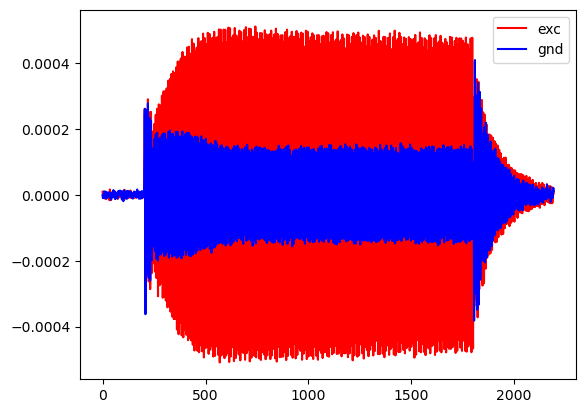

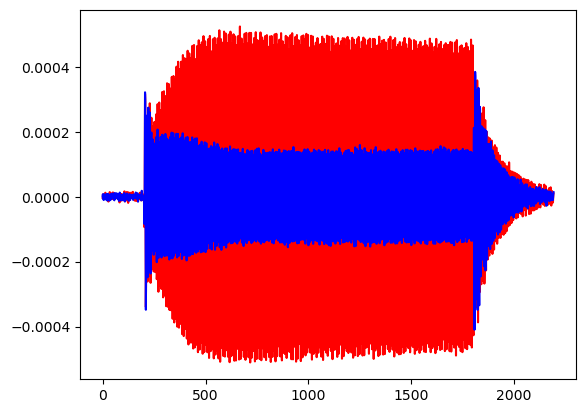

In [43]:
g_raw = np.mean(results_g, axis = 0)
e_raw = np.mean(results_e, axis = 0)

plt.plot(np.real(e_raw),c='red', label='exc')
plt.plot(np.real(g_raw),c='blue', label='gnd')
plt.legend()
plt.figure()

plt.plot(np.imag(e_raw),'r')
plt.plot(np.imag(g_raw),'b')

In [44]:
e_raw = e_raw[:-(len(e_raw)%16)]    
g_raw = g_raw[:-(len(g_raw)%16)]


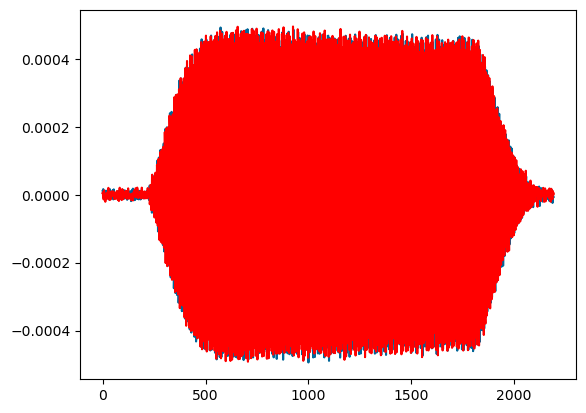

In [45]:

samples_kernel = np.conj(e_raw - g_raw)
plt.figure()
plt.plot(samples_kernel.real)
plt.plot(samples_kernel.imag)

In [46]:
def exp_int(
    qubit,
    drive_pulse,
    readout_pulse,
    integration_kernel,
    num_averages=2**8,
    use_modulated_kernel=False,
    acquisition_type=AcquisitionType.INTEGRATION,
    threshold=0.0,
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_int = Experiment(
        uid="Exp_integration",
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    measure_pulse = readout_pulse(qubit)
    print(f"measure pulse length {measure_pulse.length}")
    try:
        integration_kernel= integration_kernel(qubit)
    except Exception as e:
        print(e)
        integration_kernel = integration_kernel
    with exp_int.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        #acquisition_type=AcquisitionType.RAW,
        acquisition_type=acquisition_type,
    ):
        with exp_int.section(uid="gnd_measure"):
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=measure_pulse,
                handle=f"{qubit.uid}_int_g",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
        with exp_int.section(uid="excitation",play_after="gnd_measure"):
            exp_int.play(signal=f"drive_{qubit.uid}", pulse = drive_pulse(qubit))
        with exp_int.section(uid="exc_measure",play_after="excitation"):
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=measure_pulse,
                handle=f"{qubit.uid}_int_e",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    if not use_modulated_kernel:
        cal = Calibration()

        cal[f"acquire_{qubit.uid}"] = SignalCalibration(
            oscillator=Oscillator(frequency=0),
            threshold=threshold
        )
        exp_int.set_calibration(cal)
    return exp_int


In [47]:
normalized_samples_kernel=samples_kernel/np.max(np.abs(samples_kernel))

In [48]:
np.abs(samples_kernel)

array([1.22080521e-05, 8.29628743e-06, 6.15094383e-06, ...,
       7.14147624e-06, 8.30505014e-06, 8.21791464e-06])

In [61]:
do_rotation = True
modulate_kernel = False
#modulate_kernel = True
rotation_angle=-2.16
int_kernel = pulse_library.sampled_pulse_complex(
        normalized_samples_kernel * np.exp(1j * rotation_angle)
    )
#int_kernel = integration_kernel
my_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
    use_modulated_kernel=modulate_kernel,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_int = session.run(my_exp)


measure pulse length 8e-07
'PulseSampledComplex' object is not callable
2023.09.28 15:25:46.508 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:25:46.509 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:25:46.522 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:25:47.920 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:25:48.066 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:25:48.267 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:25:48.270 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:25:48.277 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.28 15:25:48.278 laboneq.compiler.workflow.compiler INFO   Total sample 

Using threshold = 3.227189e-01 and rotation angle: -3.181839e-01


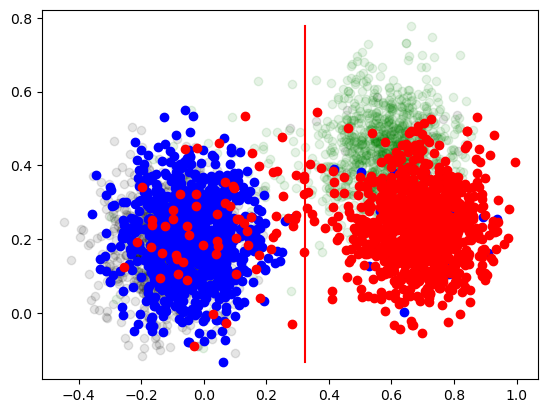

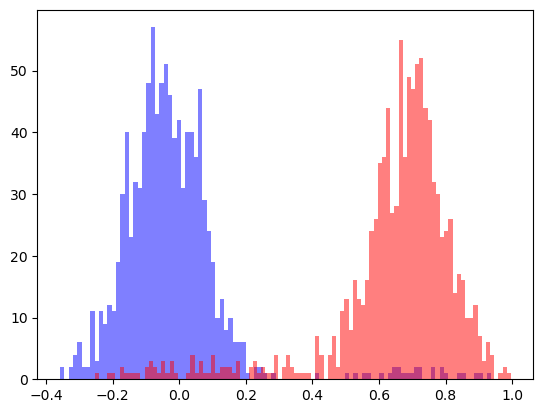

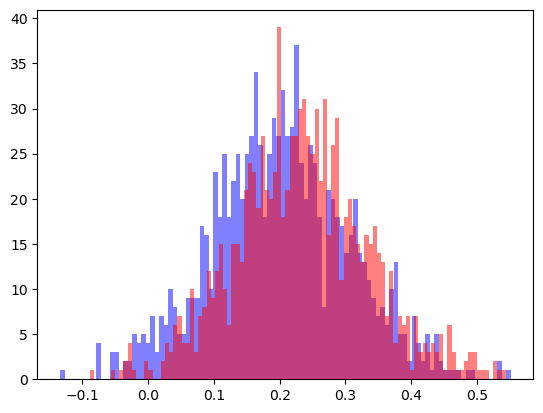

In [62]:
res0 = res_int.get_data("q0_int_g")
res1 = res_int.get_data("q0_int_e")

connect_vector = np.median(res1) - np.median(res0)
if do_rotation:
    rotation_angle = -np.angle(connect_vector)
else:
    rotation_angle = 0

res0_rot = res0 * np.exp(1j * rotation_angle)
res1_rot = res1 * np.exp(1j * rotation_angle)

my_threshold = (np.median(res0_rot.real) + np.median(res1_rot.real)) / 2

if do_rotation:
    plt.scatter(res0.real, res0.imag, c="k", alpha=0.1)
    plt.scatter(res1.real, res1.imag, c="g", alpha=0.1)

plt.scatter(res0_rot.real, res0_rot.imag, c="b")
plt.scatter(res1_rot.real, res1_rot.imag, c="r")
plt.plot(
    [my_threshold, my_threshold],
    [
        min([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
        max([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
    ],
    "r",
)
if do_rotation:
    print(f"Using threshold = {my_threshold:e} and rotation angle: {rotation_angle:e}")
else:
    print(f"Using threshold={my_threshold:e}")

plt.figure()
plt.hist(res0_rot.real, bins=100, alpha=0.5,color="blue");
plt.hist(res1_rot.real, bins=100, alpha=0.5,color="red");

plt.figure()
plt.hist(res0_rot.imag, bins=100, alpha=0.5,color="blue");
plt.hist(res1_rot.imag, bins=100, alpha=0.5,color="red");

# Calculate Fidelity

In [63]:
def calculate_fidelity(res0_rot,res1_rot,threshold):
    prepared_g_measured_g = np.count_nonzero(res0_rot.real < threshold)/len(res0_rot.real)
    prepared_g_measured_e = np.count_nonzero(res0_rot.real > threshold)/len(res0_rot.real)
    prepared_e_measured_g = np.count_nonzero(res1_rot.real < threshold)/len(res1_rot.real)
    prepared_e_measured_e = np.count_nonzero(res1_rot.real > threshold)/len(res1_rot.real)

    # plot heatmap with 4 squares
    assignment_matrix =[ [prepared_g_measured_g,prepared_g_measured_e],[prepared_e_measured_g,prepared_e_measured_e]]

    fig, ax = plt.subplots()
    im = ax.imshow(assignment_matrix, cmap='Reds', vmin=0, vmax=1)
    for i in range(2):
        for j in range(2):
            # add text annotations format with 2 decimals float
            text = ax.text(j, i, f"{assignment_matrix[i][j]:.2f}",
                        ha="center", va="center", color="black", fontsize=16)
    # plot colorbar to the right, label it with label with font size
    cbar = ax.figure.colorbar(im, ax=ax,)
    cbar.set_label( label="Assignment Probability",size=16)

    # set axis labels
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))

    ax.set_xticklabels(["g", "e"], fontsize=16)
    ax.set_yticklabels(["g", "e"], fontsize=16)
    ax.set_xlabel("Prepared State",fontsize=16)

    fidelity = (  1- prepared_g_measured_e - prepared_e_measured_g )
    print(f"ee:{prepared_e_measured_e}")
    print(f"gg:{prepared_g_measured_g}")
    print(f"eg:{prepared_e_measured_g}")
    print(f"ge:{prepared_g_measured_e}")
    print(f"Fidelity {fidelity}")

    ax.text(0.5, 2.0, f"Average Fidelity {fidelity:.2f}", size=16, ha="center")
    plt.tight_layout()

    return fidelity

ee:0.9326171875
gg:0.97265625
eg:0.0673828125
ge:0.02734375
Fidelity 0.9052734375


0.9052734375

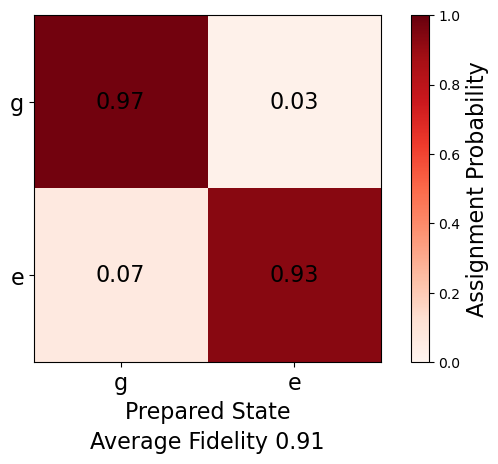

In [64]:
calculate_fidelity(res0_rot,res1_rot,my_threshold)

# Discrimination exp

In [65]:
disc_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
    use_modulated_kernel=False,
    acquisition_type=AcquisitionType.DISCRIMINATION,
    threshold=my_threshold,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_disc = session.run(disc_exp)

measure pulse length 8e-07
'PulseSampledComplex' object is not callable
2023.09.28 15:26:01.551 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 15:26:01.552 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 15:26:01.559 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 15:26:02.982 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 15:26:03.131 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 15:26:03.381 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 15:26:03.385 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 15:26:03.390 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.28 15:26:03.391 laboneq.compiler.workflow.compiler INFO   Total sample 

In [67]:
print(res_disc.acquired_results)
res_dis_q0_g=res_disc.get_data("q0_int_g")
res_dis_q0_e=res_disc.get_data("q0_int_e")
print(np.mean(res_dis_q0_g))
print(np.mean(res_dis_q0_e))

{'q0_int_g': AcquiredResult(data=array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]), axis_name=['shots'], axis=[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
       1.023e+03])], last_nt_step=[]), 'q0_int_e': AcquiredResult(data=array([1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]), axis_name=['shots'], axis=[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
       1.023e+03])], last_nt_step=[])}
(0.025390625+0j)
(0.912109375+0j)


# Active reset

In [142]:
def gen_active_reset_exp(
    qubit,
    integration_kernel,
    prepare_pulse:callable,
    pi_pulse: callable,
    readout_pulse,
    prepare_pulse_phase =0,
    num_average=1024,
    threshold=0,
    num_rst=10,
):
    exp = Experiment(
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )

    with exp.acquire_loop_rt(
        count=num_average,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.DISCRIMINATION,
    ):

        # qubit state readout
        with exp.section(uid="prepare"):
            exp.play(signal=f"drive_{qubit.uid}", pulse=prepare_pulse(qubit),amplitude=1, phase = prepare_pulse_phase)

        for i in range(num_rst):
            if i==0:
                measure_playafter="prepare"
            else:
                measure_playafter=f"feedback_{i-1}"
            with exp.section(uid=f"measure_{i}",play_after=measure_playafter):
                exp.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_bf_rst_{i}",
                    #handle="fb_measure",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel,
                    reset_delay=500e-9,
                )

            with exp.match(
                uid=f"feedback_{i}",
                handle=f"{qubit.uid}_bf_rst_{i}",
                #andle="fb_measure",
                play_after=f"measure_{i}",
            ):
                with exp.case(state=0):
                    exp.play(signal=f"drive_{qubit.uid}", pulse=pi_pulse(qubit),amplitude=0)
                with exp.case(state=1):
                    # play x180 pulse
                    exp.play(signal=f"drive_{qubit.uid}", pulse=pi_pulse(qubit),amplitude=1)
        with exp.section(uid=f"posmeasure",play_after=f"feedback_{num_rst-1}"):
            exp.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=readout_pulse(qubit),
                handle=f"{qubit.uid}_rst",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    cal= Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=Oscillator(frequency=0),
        port_delay=240e-9,
        threshold=threshold,
    )

    exp.set_calibration(cal)

    return exp

In [176]:
reset_exp = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_drive_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=3,
)

session.connect(do_emulation=emulate, reset_devices=True)
res_reset = session.run(reset_exp)
show_pulse_sheet("reset", res_reset.compiled_experiment)
res_bf_rst = np.real(res_reset.get_data(f"q0_bf_rst_0"))
res_aft_rst = np.real(res_reset.get_data("q0_rst"))
print(np.count_nonzero(res_bf_rst)/len(res_bf_rst))
print(np.count_nonzero(res_aft_rst)/len(res_aft_rst))

2023.09.28 16:57:24.736 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.28 16:57:24.737 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.28 16:57:24.747 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.28 16:57:26.164 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.28 16:57:26.304 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.28 16:57:26.540 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.28 16:57:26.544 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.28 16:57:26.551 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 36
2023.09.28 16:57:26.551 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4624
2023.09.28 16:57:26.551 laboneq.compiler.workflow

# Active reset fidelity as a function of number of reset cycles

In [143]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

def empty_pulse(qubit):
    return pulse_library.gaussian(
        length = qubit.parameters.user_defined["pulse_length"],
        amplitude=0,
    )

In [233]:
num_avg_reset = 2**13


In [240]:
res_rst_e=[]
std_res_rst_e=[]
session.connect(do_emulation=emulate, reset_devices=True)
num_rst = 50
reset_exp_e = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_drive_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
)
    
res_reset_exp_e = session.run(reset_exp_e)
for i in range(num_rst):
    rst=np.real(res_reset_exp_e.get_data(f"q0_bf_rst_{i}"))
    #aft_rst=np.real(res_reset.get_data("q0_rst"))
    #res_rst_e.append(np.count_nonzero(rst)/len(rst))
    res_rst_e.append(np.mean(rst))
    std_res_rst_e.append(np.std(rst))


2023.09.29 13:54:44.786 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 13:54:44.787 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 13:54:44.798 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 13:54:46.223 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 13:54:46.403 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 13:54:46.651 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 13:54:46.665 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 13:54:46.701 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 130
2023.09.29 13:54:46.701 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4624
2023.09.29 13:54:46.702 laboneq.compiler.workflo

In [241]:
res_rst_g=[]
std_res_rst_g=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_g = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = empty_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
)
    
res_reset_exp_g = session.run(reset_exp_g)
for i in range(num_rst):
    rst=np.real(res_reset_exp_g.get_data(f"q0_bf_rst_{i}"))
    #aft_rst=np.real(res_reset.get_data("q0_rst"))
    #res_rst_g.append(np.count_nonzero(rst)/len(rst))
    res_rst_g.append(np.mean(rst))
    std_res_rst_g.append(np.std(rst))


2023.09.29 13:54:52.610 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 13:54:52.611 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 13:54:52.616 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 13:54:54.047 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 13:54:54.192 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 13:54:54.432 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 13:54:54.459 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 13:54:54.497 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.09.29 13:54:54.497 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.09.29 13:54:54.498 laboneq.compiler.workflo

In [242]:
res_rst_plus=[]
std_res_rst_plus=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_plus = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
)
    
res_reset_exp_plus = session.run(reset_exp_plus)
for i in range(num_rst):
    rst=np.real(res_reset_exp_plus.get_data(f"q0_bf_rst_{i}"))
    res_rst_plus.append(np.mean(rst))
    std_res_rst_plus.append(np.std(rst))


2023.09.29 13:55:08.270 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 13:55:08.271 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 13:55:08.277 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 13:55:09.726 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 13:55:09.874 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 13:55:10.106 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 13:55:10.122 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 13:55:10.157 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.09.29 13:55:10.158 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.09.29 13:55:10.159 laboneq.compiler.workflo

In [252]:
res_rst_minus=[]
std_res_rst_minus=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_minus = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
    prepare_pulse_phase=np.pi,
)
    
res_reset_exp_minus = session.run(reset_exp_minus)
for i in range(num_rst):
    rst=np.real(res_reset_exp_minus.get_data(f"q0_bf_rst_{i}"))
    res_rst_minus.append(np.mean(rst))
    std_res_rst_minus.append(np.std(rst))

2023.09.29 14:07:27.158 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 14:07:27.159 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 14:07:27.165 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 14:07:28.610 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 14:07:28.760 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 14:07:28.984 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 14:07:29.002 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 14:07:29.041 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.09.29 14:07:29.041 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.09.29 14:07:29.042 laboneq.compiler.workflo

In [253]:
res_rst_plus_i=[]
std_res_rst_plus_i=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_plus_i = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
    prepare_pulse_phase=np.pi/2,
)
    
res_reset_exp_plus_i = session.run(reset_exp_plus_i)
for i in range(num_rst):
    rst=np.real(res_reset_exp_plus_i.get_data(f"q0_bf_rst_{i}"))
    res_rst_plus_i.append(np.mean(rst))
    std_res_rst_plus_i.append(np.std(rst))

2023.09.29 14:07:34.168 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 14:07:34.169 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 14:07:34.174 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 14:07:35.662 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 14:07:35.809 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 14:07:36.049 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 14:07:36.065 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 14:07:36.100 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.09.29 14:07:36.100 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.09.29 14:07:36.101 laboneq.compiler.workflo

In [254]:
res_rst_minus_i=[]
std_res_rst_minus_i=[]
session.connect(do_emulation=emulate, reset_devices=True)
reset_exp_minus_i = gen_active_reset_exp(
    qubit=transmon_list[0],
    prepare_pulse = qubit_gaussian_halfpi_pulse,
    pi_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    threshold=my_threshold,
    num_rst=num_rst,
    num_average=num_avg_reset,
    prepare_pulse_phase= -np.pi/2,
)
    
res_reset_exp_minus_i = session.run(reset_exp_minus_i)
for i in range(num_rst):
    rst=np.real(res_reset_exp_minus_i.get_data(f"q0_bf_rst_{i}"))
    res_rst_minus_i.append(np.mean(rst))
    std_res_rst_minus_i.append(np.std(rst))

2023.09.29 14:07:41.271 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.29 14:07:41.272 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.29 14:07:41.280 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.29 14:07:42.669 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.29 14:07:42.809 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.29 14:07:43.050 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.29 14:07:43.070 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.29 14:07:43.106 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 133
2023.09.29 14:07:43.106 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 5040
2023.09.29 14:07:43.106 laboneq.compiler.workflo

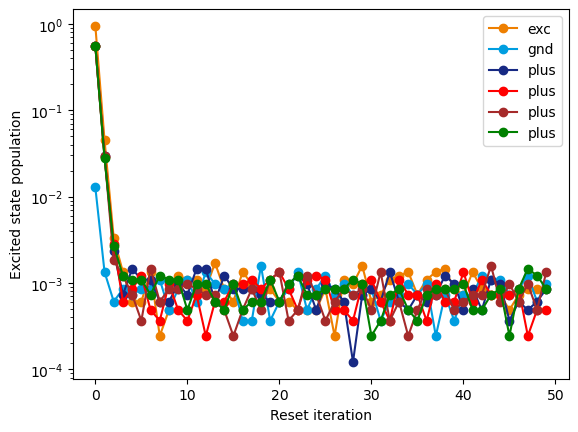

In [257]:
num_rst_ite = np.arange(0,len(res_rst_e))
# plot log of population
plt.figure()

# plot semlogy with error bar
plt.semilogy(num_rst_ite,res_rst_e,'-o',label='exc',color=orange_color_zi)
plt.semilogy(num_rst_ite,res_rst_g,'-o',label='gnd',color=blue_color_zi)
plt.semilogy(num_rst_ite,res_rst_plus,'-o',label='plus',color=dark_blue_color_zi)
plt.semilogy(num_rst_ite,res_rst_minus,'-o',label='plus',color="red")
plt.semilogy(num_rst_ite,res_rst_plus_i,'-o',label='plus',color="brown")
plt.semilogy(num_rst_ite,res_rst_minus_i,'-o',label='plus',color="green")

plt.xlabel('Reset iteration')
plt.ylabel('Excited state population')
plt.legend()

[0.00e+00 1.70e-06 3.40e-06 5.10e-06 6.80e-06 8.50e-06 1.02e-05 1.19e-05
 1.36e-05 1.53e-05]


In [191]:
def t1_optimized_kernel(
    qubits,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    delay_sweep,
    num_averages=2**10,
    acquisition_type = AcquisitionType.DISCRIMINATION,
    threshold=0,
):
    exp_t1 = Experiment(
        uid="T1 Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_t1.acquire_loop_rt(
        uid="t1_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=acquisition_type,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of T1 time delays
        with exp_t1.sweep(
            uid="t1_delay_sweep",
            parameter=delay_sweep,
            alignment=SectionAlignment.RIGHT,
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                with exp_t1.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_t1.play(signal=f"drive_{qubit.uid}", pulse=drive_pulse(qubit))
                    exp_t1.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                # readout pulse and data acquisition
                # measurement
                with exp_t1.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_t1.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_t1",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel,
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
    cal= Calibration()
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        oscillator=Oscillator(frequency=0),
        port_delay=240e-9,
        threshold=threshold,
    )

    exp_t1.set_calibration(cal)

    return exp_t1

In [234]:
#delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)
delay_sweep_cnt = 200
time_step = 1.7e-6
stop = (delay_sweep_cnt-1)*time_step
delay_sweep = LinearSweepParameter(start=0, stop=stop, count=delay_sweep_cnt)
t1_meas = t1_optimized_kernel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=int_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=num_avg_reset,
    threshold=my_threshold,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

[0.000e+00 1.700e-06 3.400e-06 5.100e-06 6.800e-06 8.500e-06 1.020e-05
 1.190e-05 1.360e-05 1.530e-05 1.700e-05 1.870e-05 2.040e-05 2.210e-05
 2.380e-05 2.550e-05 2.720e-05 2.890e-05 3.060e-05 3.230e-05 3.400e-05
 3.570e-05 3.740e-05 3.910e-05 4.080e-05 4.250e-05 4.420e-05 4.590e-05
 4.760e-05 4.930e-05 5.100e-05 5.270e-05 5.440e-05 5.610e-05 5.780e-05
 5.950e-05 6.120e-05 6.290e-05 6.460e-05 6.630e-05 6.800e-05 6.970e-05
 7.140e-05 7.310e-05 7.480e-05 7.650e-05 7.820e-05 7.990e-05 8.160e-05
 8.330e-05 8.500e-05 8.670e-05 8.840e-05 9.010e-05 9.180e-05 9.350e-05
 9.520e-05 9.690e-05 9.860e-05 1.003e-04 1.020e-04 1.037e-04 1.054e-04
 1.071e-04 1.088e-04 1.105e-04 1.122e-04 1.139e-04 1.156e-04 1.173e-04
 1.190e-04 1.207e-04 1.224e-04 1.241e-04 1.258e-04 1.275e-04 1.292e-04
 1.309e-04 1.326e-04 1.343e-04 1.360e-04 1.377e-04 1.394e-04 1.411e-04
 1.428e-04 1.445e-04 1.462e-04 1.479e-04 1.496e-04 1.513e-04 1.530e-04
 1.547e-04 1.564e-04 1.581e-04 1.598e-04 1.615e-04 1.632e-04 1.649e-04
 1.666

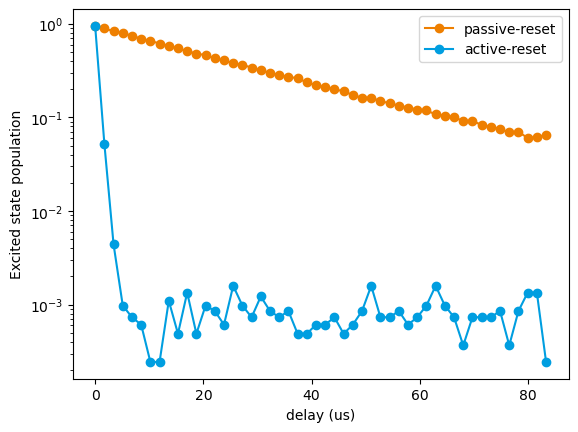

In [239]:
t1_data =t1_res.get_data("q0_t1")
plot_delay=delay_sweep.values[:num_rst]*1e6
plt.figure()
plt.semilogy(plot_delay,np.real(t1_data[:num_rst]),"-o",color=orange_color_zi,label='passive-reset')
plt.semilogy(plot_delay,np.real(res_rst_e),"-o",color=blue_color_zi,label='active-reset')
plt.xlabel(f"delay (us)")
plt.ylabel("Excited state population")
plt.legend()
#plt.axvline(x=t1*1e6, color='gray', linestyle='--', linewidth=2)
#plt.text(x=2*t1*1e6,y= max(y)/2,s=f"T1= {t1*1e6:.3f}us.")

T1 found to be 25.257 us.


2.525696083579902e-05

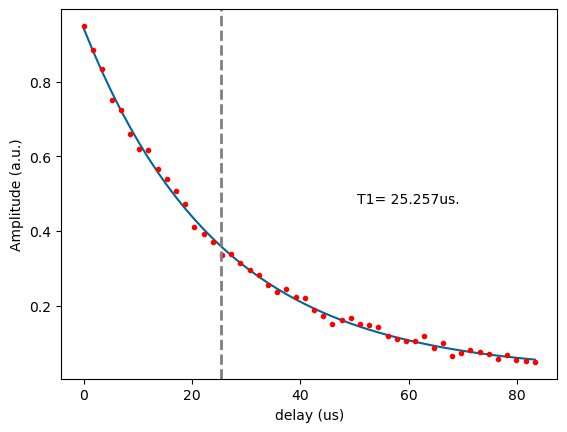

In [200]:
evaluate_T1(t1_res, "q0_t1")
#plt.plot(t1_res.acquired_results["q0_t1"].data.real,'-o')